<a href="https://colab.research.google.com/github/piyush-bhandari-commits/self-learn-repo/blob/master/Text_Classification_H2O_AutoML_and_TF_IDF_%5BUS_Banks_Consumer_Complaints%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [2]:
!pip install h2o

     |████████████████████████████████| 129.3MB 93kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.1-py2.py3-none-any.whl size=129358602 sha256=b2c8e189e0e4f67be4f93e8591ba9090227563e6b3f9b7385925547f83a1ff96
  Stored in directory: /root/.cache/pip/wheels/33/ac/52/165c35d747abdb629c3c9fb7e087f360c662d8cb58824caed8
Successfully built h2o


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns
from pprint import pprint
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptzbwt9o1
  JVM stdout: /tmp/tmptzbwt9o1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptzbwt9o1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_wlvgck
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
# Fetching the dataset from the data.gov website
url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'
actual_data = pd.read_csv(url, compression='zip')

In [7]:
# Pre-preocessing the actual dataset
print ('Shape of Actual Data: {}'.format(actual_data.shape))

Shape of Actual Data: (1732604, 18)


In [8]:
actual_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


In [9]:
raw_dataset = actual_data[[actual_data.columns[1], actual_data.columns[5], actual_data.columns[7]]].rename(columns={'Consumer complaint narrative': 'Complaint'})
clean_raw_dataset = raw_dataset.dropna()
print('The dataset has {} rows and {} columns'.format(clean_raw_dataset.shape[0], clean_raw_dataset.shape[1]))
clean_raw_dataset.head()

The dataset has 586856 rows and 3 columns


,Product,Complaint,Company
0,Debt collection,transworld systems inc. \nis trying to collect...,TRANSWORLD SYSTEMS INC
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,"TRANSUNION INTERMEDIATE HOLDINGS, INC."
3,Debt collection,"Over the past 2 weeks, I have been receiving e...","Diversified Consultants, Inc."
6,Credit card or prepaid card,Received a text message about an hour ago to l...,"CITIBANK, N.A."
7,"Credit reporting, credit repair services, or o...",I have lodged disputes with DYCK O'Neal with t...,"Dyck-O'Neal, Inc."


In [10]:
clean_raw_dataset['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    198064
Debt collection                                                                 120524
Mortgage                                                                         68151
Credit card or prepaid card                                                      41487
Credit reporting                                                                 31588
Student loan                                                                     26766
Checking or savings account                                                      24000
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               10196
Vehicle loan or lease                                                            10070
Consumer Loan                              

In [11]:
# label_count = clean_raw_dataset['Product'].value_counts().to_dict()
# for label, count in label_count.items():
#     if count < 10000:
#         clean_raw_dataset = clean_raw_dataset.drop(clean_raw_dataset[clean_raw_dataset.Product.values == label].index)

In [12]:
# clean_raw_dataset.Product.value_counts()

In [13]:
# from imblearn.under_sampling import RandomUnderSampler

# X = clean_raw_dataset['Complaint'].values.reshape(-1,1)
# y = clean_raw_dataset['Product'].values.reshape(-1,1)
# sample = RandomUnderSampler()
# X_under, y_under = sample.fit_resample(X, y)

In [14]:
# dataset = pd.DataFrame(data=X_under, columns=['Complaint'])
# dataset['Product'] = y_under
# dataset.head()

In [27]:
dataset = clean_raw_dataset.sample(n=100000)
dataset['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    33612
Debt collection                                                                 20450
Mortgage                                                                        11653
Credit card or prepaid card                                                      7144
Credit reporting                                                                 5387
Student loan                                                                     4558
Checking or savings account                                                      4118
Credit card                                                                      3242
Bank account or service                                                          2531
Vehicle loan or lease                                                            1754
Money transfer, virtual currency, or money service                               1696
Consumer Loan                                         

In [28]:
label_count = dataset['Product'].value_counts().to_dict()
for label, count in label_count.items():
    if count < 3000 or count > 21000:
        dataset = dataset.drop(dataset[dataset.Product.values == label].index)

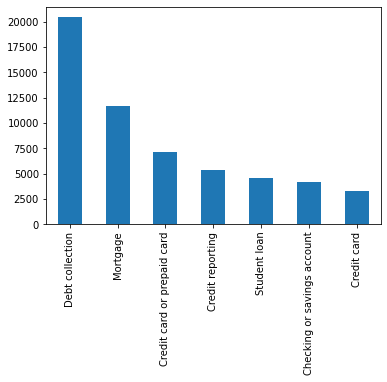

In [29]:
dataset.Product.value_counts().plot(kind='bar')

In [30]:
mapping = {}
for value in np.arange(len(np.unique(dataset.Product.values))):
    mapping[np.unique(dataset.Product.values)[value]] = value 

In [31]:
mapping

{'Checking or savings account': 0,
 'Credit card': 1,
 'Credit card or prepaid card': 2,
 'Credit reporting': 3,
 'Debt collection': 4,
 'Mortgage': 5,
 'Student loan': 6}

In [32]:
from sklearn.utils import shuffle
dataset['Target'] = dataset.Product.map(mapping)
dataset = shuffle(dataset)
dataset.head()

,Product,Complaint,Company,Target
1596321,Student loan,XX/XX/XXXX : I was able to pay a pass due amou...,"Navient Solutions, LLC.",6
1302355,Credit card,I recently sent an online secure message to Ca...,CAPITAL ONE FINANCIAL CORPORATION,1
1683660,Mortgage,On XX/XX/2018 ; I applied for a mortgage loan ...,"Aurora Financial, LLC",5
1643801,Debt collection,XXXX XXXX XXXX XXXX XXXX is calling me 10-15 t...,"General Motors Financial Company, Inc.",4
1432581,Credit card,I opened a Chase Amazon Rewards credit card a ...,JPMORGAN CHASE & CO.,1


In [33]:
# Splitting data into train and test set
train, test = train_test_split(dataset, test_size=0.20, random_state=42)

In [34]:
print ('Shape of Train Data : {}'.format(train.shape))
print ('Shape of Test Data : {}'.format(test.shape))

Shape of Train Data : (45241, 4)
Shape of Test Data : (11311, 4)


In [35]:
pprint (train['Complaint'].values[10])

('American Express Serve card has been in a total system outage for over 12 '
 'hours.Members cannot access their account information nor use the Card for '
 'purchases.Off-shore customer service reps are rude and non-responsive - '
 'refusing to answer questions, and often times outright hanging up the '
 'phone.No ETA for restoration is provided.Card is still offline.')


In [36]:
pprint (train['Complaint'].values[28])

('I did miss a payment in XX/XX/XXXX. Due to my finances I was unable to bring '
 'my account current until XX/XX/XXXX All other payments were made. I have '
 'payed receipts for all payments. All payments were made at Bank of America '
 'bank or pay by phone, a Bank of America XXXX number printed on thier monthly '
 'bill to pay. Last month I received a packet from the Bank of America stating '
 'forecloure is being started and XXXX the month of forecloure. I then called '
 'XXXX XXXX XXXX. XXXX XXXX XXXX was the XXXX assigned to help me. \n'
 'A letter was sent to the bank and the foreclosure was dropped. Now as per my '
 'records back payments were brought up to date. XXXX XXXX sent a letter '
 'requesting a report from the bank listing all payments made. No report has '
 'been made or sent to me or any contact from the bank by letter or phone. \n'
 'When the account was brought to date by my records the bank showed a balance '
 "of {$1600.00} still due. A report of Bank 's payments

In [37]:
pprint (train['Complaint'].values[32])

('We have a {$440000.00}, interest only, equity line loan with Bank Of America '
 'that will change from an interest only payment to an amortized payment '
 'starting XXXX 2015 after XXXX years. It is a XXXX year loan. The XXXX XXXX '
 'years are interest only. The next 15 years are amortized. This loan is in '
 'the XXXX position. Our XXXX is a XXXX year loan has under XXXX yrs left on '
 'it. Most of our mortgage payment for the XXXX now goes against our '
 'principle. Bank of America has sent us a letter stating that our loan will '
 'change XXXX 2015 and our monthly payment will be adjusted from {$1100.00} a '
 'month to {$3600.00} a month starting XXXX 2015. An amount we can not afford '
 'to pay. \n'
 'We went to go see XXXX XXXX, Mortgage Broker, at our local Bank of America '
 'office, at XXXX XXXX XXXX, XXXX, CA XXXX, XXXX on XXXX XXXX, 2015, to get '
 'our equity line refinanced or to streamline our XXXX loans. She informed us '
 'that Bank of America could not refinance our 

In [38]:
lemma = WordNetLemmatizer()

porter = nltk.PorterStemmer()

def clean_text(text):
    no_url_text = re.sub(r"http\S+", "", text)
    
    no_punct_text = re.sub("[^a-zA-Z#]", " ", no_url_text)
    
    no_num_text = re.sub("\d+{4-6}", " ", no_punct_text)

    no_encrypt_text = " ".join([word.strip('Xx/') for word in no_num_text.split()])
                               
    no_small_text = " ".join([word for word in no_encrypt_text.split() if len(word)>2])
    
    no_stop_text = " ".join([word for word in no_small_text.split() if word not in stopwords])
    
    # lemma_text = " ".join([lemma.lemmatize(word) for word in no_stop_text.split()])
    # stem_text = " ".join([porter.stem(word) for word in no_stop_text.split()])
    
    tokens = re.split('\W+', no_stop_text)
    return tokens

train['Complaint Tokens'] = train['Complaint'].apply(lambda x: clean_text(x.lower()))
train['Complaint Sentence'] = train['Complaint Tokens'].apply(lambda x: " ".join(x))
train.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Product,Complaint,Company,Target,Complaint Tokens,Complaint Sentence
1591956,Debt collection,contacted company asking about the Hippa laws ...,"Advanced Collection Bureau, Inc.",4,"[contacted, company, asking, hippa, laws, viol...",contacted company asking hippa laws violation ...
1336896,Debt collection,I recieved a letter requesting payment on a de...,"First National Collection Bureau, Inc.",4,"[recieved, letter, requesting, payment, debt, ...",recieved letter requesting payment debt may fo...
1338657,Credit reporting,Experian have violated the Violation of the Fa...,Experian Information Solutions Inc.,3,"[experian, violated, violation, fair, credit, ...",experian violated violation fair credit report...
1730299,Debt collection,I was living at an apartment complex with my n...,"ProCollect, Inc.",4,"[living, apartment, comple, wife, mother, offe...",living apartment comple wife mother offered ho...
1456347,Credit reporting,"Once again, I 'm making another complaint agai...","TRANSUNION INTERMEDIATE HOLDINGS, INC.",3,"[making, another, complaint, transunion, failu...",making another complaint transunion failure re...


In [39]:
x_train = train['Complaint Sentence']
y_train = train['Target']

x_test = test['Complaint']
y_test = test['Target']
x_train.head()

1591956    contacted company asking hippa laws violation ...
1336896    recieved letter requesting payment debt may fo...
1338657    experian violated violation fair credit report...
1730299    living apartment comple wife mother offered ho...
1456347    making another complaint transunion failure re...
Name: Complaint Sentence, dtype: object

In [40]:
pprint (train['Complaint Sentence'].values[32])

('interest equity line loan bank america change interest payment amortized '
 'payment starting years year loan years interest next years amortized loan '
 'position year loan yrs left mortgage payment goes principle bank america '
 'sent letter stating loan change monthly payment adjusted month month '
 'starting amount afford pay went see mortgage broker local bank america '
 'office get equity line refinanced streamline loans informed bank america '
 'could refinance loan streamline loan loans bank america suggested contact '
 'modification office heard getting loan modified rarely happens terrible deal '
 'get modification take months get done hurts credit income mortgage '
 'percentage way acceptable range traditional refinance credit rating late '
 'mortgage payment years wife also works industry good credit history ability '
 'weather economic turn think options besides income mortgage percentage fact '
 'never late mortgage payment years fact independent businessman ups downs '

In [41]:
pprint (train['Complaint Sentence'].values[28])

('miss payment due finances unable bring account current payments made payed '
 'receipts payments payments made bank america bank pay phone bank america '
 'number printed thier monthly bill pay last month received packet bank '
 'america stating forecloure started month forecloure called assigned help '
 'letter sent bank foreclosure dropped per records back payments brought date '
 'sent letter requesting report bank listing payments made report made sent '
 'contact bank letter phone account brought date records bank showed balance '
 'still due report bank payments received would help resolve matter previously '
 'requested please help resolve matter bank seems interested resoving matter '
 'sincerely cell')


In [42]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=1000, ngram_range=(1,2))
x_train_vect = tfidf_vectorizer.fit_transform(x_train)
x_test_vect = tfidf_vectorizer.fit_transform(x_test)

In [43]:
df_train = pd.DataFrame(x_train_vect.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_train = pd.concat([df_train, train['Target'].reset_index(drop=True)], axis=1)

In [44]:
df_test = pd.DataFrame(x_test_vect.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_test = pd.concat([df_test, test['Target'].reset_index(drop=True)], axis=1)

In [45]:
h2o_train_df = h2o.H2OFrame(df_train)
h2o_test_df = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [46]:
h2o_train_df['Target'] = h2o_train_df['Target'].asfactor()
h2o_test_df['Target'] = h2o_test_df['Target'].asfactor()

In [47]:
auto_ml = H2OAutoML(max_models=5, seed=10, exclude_algos=["StackedEnsemble"], verbosity="info", balance_classes=True, max_after_balance_size=0.30)

In [48]:
x = tfidf_vectorizer.get_feature_names()
y = 'Target'

In [49]:
auto_ml.train(x=x, y=y, training_frame=h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
20:35:32.934: Project: AutoML_20200829_203532930
20:35:32.935: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
20:35:32.947: Setting stopping tolerance adaptively based on the training frame: 0.00470147252022672
20:35:32.947: Build control seed: 10
20:35:32.950: training frame: Frame key: automl_training_py_1_sid_8272    cols: 1001    rows: 45241  chunks: 52    size: 34660777  checksum: 7514466310663989552
20:35:32.962: validation frame: Frame key: py_2_sid_8272    cols: 1001    rows: 11311  chunks: 16    size: 17323791  checksum: 1016134921362180374
20:35:32.962: leaderboard frame: NULL
20:35:32.962: blending frame: NULL
20:35:32.962: response column: Target
20:35:32.963: fold column: null
20:35:32.963: weights column: null
20:35:33.3: Loading execution steps:

In [50]:
auto_ml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20200829_203532,0.251601,0.479006,0.381286,0.145379
XGBoost_2_AutoML_20200829_203532,0.251616,0.483289,0.37945,0.143982
XGBoost_3_AutoML_20200829_203532,0.256382,0.478268,0.385943,0.148952
GLM_1_AutoML_20200829_203532,0.263755,0.514313,0.401147,0.160919
DRF_1_AutoML_20200829_203532,0.344388,0.732177,0.504366,0.254385


In [51]:
auto_ml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1,p2,p3,p4,p5,p6
5,0.00818534,0.00453254,0.131441,0.0255893,0.0127732,0.609881,0.207598
5,0.00668448,0.00177355,0.00450273,0.0100204,0.163419,0.802563,0.0110361
4,0.0730781,0.012549,0.0352195,0.304713,0.499189,0.0644946,0.0107569
5,0.00244294,0.0089764,0.0171226,0.035466,0.0229878,0.902208,0.0107959
5,0.00502339,0.0091935,0.0362491,0.0133355,0.00650694,0.91417,0.0155212
5,0.00196798,0.0384649,0.0259137,0.00359034,0.0412985,0.873866,0.0148987
5,0.0028289,0.00640645,0.0105718,0.0681186,0.0992339,0.800432,0.012408
4,0.00179454,0.206273,0.183251,0.0106686,0.444875,0.0444926,0.108645
6,0.18964,0.0135237,0.173747,0.0164819,0.207996,0.139004,0.259608
5,0.0118059,0.0140462,0.0125342,0.000834448,0.0276288,0.692669,0.240482


In [52]:
auto_ml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.6685173863659686
RMSE: 0.8176291251942831
LogLoss: 2.5397137410933412
Mean Per-Class Error: 0.8437726890793568

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,6,Error,Rate
0,23.0,12.0,57.0,53.0,218.0,379.0,76.0,0.971883,795 / 818
1,12.0,10.0,32.0,35.0,250.0,267.0,45.0,0.984639,641 / 651
2,33.0,18.0,91.0,79.0,511.0,598.0,85.0,0.935689,"1,324 / 1,415"
3,10.0,17.0,69.0,55.0,454.0,421.0,56.0,0.949168,"1,027 / 1,082"
4,47.0,100.0,338.0,361.0,1614.0,1317.0,272.0,0.601383,"2,435 / 4,049"
5,54.0,33.0,115.0,160.0,732.0,1083.0,220.0,0.548185,"1,314 / 2,397"
6,14.0,14.0,37.0,49.0,269.0,440.0,76.0,0.915462,823 / 899
7,193.0,204.0,739.0,792.0,4048.0,4505.0,830.0,0.739015,"8,359 / 11,311"



Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.260985
1,2,0.454602
2,3,0.602511
3,4,0.727168
4,5,0.833260
5,6,0.922553
6,7,1.000000


In [53]:
model_ids = list(auto_ml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [54]:
model_out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 10,
  'min_child_weight': 5.0,
  'nround': 87,
  'nthread': 2,
  'num_class': 7,
  'objective': 'multi:softprob',
  'seed': 10,
  'silent': True,
  'subsample': 0.6,
  'updater': 'grow_gpu_hist'},
 87)

In [55]:
import xgboost as XGB
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
xgb_clf = XGB.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, objective='multi:softprob', random_state=44)
xgb_clf.fit(x_train_vect, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [59]:
test_predictions = xgb_clf.predict(x_test_vect)

In [60]:
cm = confusion_matrix(y_test, test_predictions)
print (cm)

[[  12    7   49  109  260  320   61]
 [  11    2   42   71  242  245   38]
 [  31    5   77  152  490  572   88]
 [  14    5   86   80  492  346   59]
 [  27   32  341  556 1657 1133  303]
 [  42    7  128  269  686 1073  192]
 [  18    1   46   94  271  401   68]]


In [61]:
print (classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.08      0.01      0.02       818
           1       0.03      0.00      0.01       651
           2       0.10      0.05      0.07      1415
           3       0.06      0.07      0.07      1082
           4       0.40      0.41      0.41      4049
           5       0.26      0.45      0.33      2397
           6       0.08      0.08      0.08       899

    accuracy                           0.26     11311
   macro avg       0.15      0.15      0.14     11311
weighted avg       0.23      0.26      0.24     11311



In [62]:
from sklearn.utils import class_weight

class_weight = list(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train))

In [63]:
class_weight

[1.9584848484848485,
 2.4944037051331533,
 1.1281200907662767,
 1.5012775842044135,
 0.39406133772330953,
 0.6982497839239412,
 1.7663295982508882]

In [64]:
weights = np.ones(x_train.shape[0], dtype='float')

In [65]:
for i, value in enumerate(y_train):
    weights[i] = class_weight[value]

In [66]:
xgb_clf = XGB.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, objective='multi:softprob', random_state=44)
xgb_clf.fit(x_train_vect, y_train, sample_weight=weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [67]:
test_predictions = xgb_clf.predict(x_test_vect)
cm = confusion_matrix(y_test, test_predictions)
print (cm)

[[  44   41   98  148  100  309   78]
 [  33   22   63   92  124  254   63]
 [  80   53  141  220  238  555  128]
 [  74   48  143  128  225  371   93]
 [ 126  232  454  807  849 1160  421]
 [ 119   89  195  412  313 1014  255]
 [  46   23   79  122  146  400   83]]


In [68]:
print (classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.08      0.05      0.07       818
           1       0.04      0.03      0.04       651
           2       0.12      0.10      0.11      1415
           3       0.07      0.12      0.09      1082
           4       0.43      0.21      0.28      4049
           5       0.25      0.42      0.31      2397
           6       0.07      0.09      0.08       899

    accuracy                           0.20     11311
   macro avg       0.15      0.15      0.14     11311
weighted avg       0.24      0.20      0.20     11311

